# Advanced ED-AI Triage System

Comprehensive implementation with ClinicalBERT, XGBoost, Temporal Fusion Transformer, and advanced interpretability.

In [6]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, brier_score_loss
from sklearn.impute import KNNImputer
import xgboost as xgb
import lightgbm as lgb
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss
import torch
from transformers import AutoTokenizer, AutoModel, pipeline
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import captum
from captum.attr import IntegratedGradients
import mlflow
import mlflow.sklearn
import mlflow.pytorch
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("Loading advanced ED datasets...")

Loading advanced ED datasets...


In [7]:
# Load datasets
diagnosis_df = pd.read_csv('../data/diagnosis.csv')
edstays_df = pd.read_csv('../data/edstays.csv')
medrecon_df = pd.read_csv('../data/medrecon.csv')
pyxis_df = pd.read_csv('../data/pyxis.csv')
triage_df = pd.read_csv('../data/triage.csv')
vitals_df = pd.read_csv('../data/vitalsign.csv')

print("Datasets loaded successfully!")
print(f"Diagnosis records: {len(diagnosis_df)}")
print(f"ED stays: {len(edstays_df)}")
print(f"Medication records: {len(medrecon_df)}")
print(f"Pyxis records: {len(pyxis_df)}")
print(f"Triage records: {len(triage_df)}")
print(f"Vital signs: {len(vitals_df)}")

Datasets loaded successfully!
Diagnosis records: 13
ED stays: 10
Medication records: 16
Pyxis records: 16
Triage records: 10
Vital signs: 20


In [14]:
print("Numeric cols NA count:")
print(merged_df[numeric_cols].isna().sum())
print("All values NaN?", merged_df[numeric_cols].isna().all())


Numeric cols NA count:
temperature_y                 13
heart_rate_y                  13
respiratory_rate_y            13
oxygen_saturation_y           13
blood_pressure_systolic_y     13
blood_pressure_diastolic_y    13
pain_score_y                  13
dtype: int64
All values NaN? temperature_y                 True
heart_rate_y                  True
respiratory_rate_y            True
oxygen_saturation_y           True
blood_pressure_systolic_y     True
blood_pressure_diastolic_y    True
pain_score_y                  True
dtype: bool


In [17]:
from sklearn.impute import KNNImputer
import pandas as pd

# ----------------------------------------------------
# Data preprocessing and feature engineering
# ----------------------------------------------------
print("Advanced data preprocessing...")

# Convert timestamps
triage_df['charttime'] = pd.to_datetime(triage_df['charttime'])
vitals_df['charttime'] = pd.to_datetime(vitals_df['charttime'])
edstays_df['intime'] = pd.to_datetime(edstays_df['intime'])
edstays_df['outtime'] = pd.to_datetime(edstays_df['outtime'])

# Sort before merge_asof
triage_df = triage_df.sort_values(['subject_id', 'charttime'])
vitals_df = vitals_df.sort_values(['subject_id', 'charttime'])

# Merge vitals with triage using nearest timestamp (within 5 minutes)
merged_df = pd.merge_asof(
    triage_df,
    vitals_df,
    on="charttime",
    by="subject_id",
    direction="nearest",
    tolerance=pd.Timedelta("5min")
)

# Merge diagnosis + ED stays
merged_df = pd.merge(merged_df, diagnosis_df.drop_duplicates("subject_id"), on="subject_id", how="left")
merged_df = pd.merge(merged_df, edstays_df.drop_duplicates("subject_id"), on="subject_id", how="left")

# Numeric cols for imputation
numeric_cols = [
    'temperature_y', 'heart_rate_y', 'respiratory_rate_y', 'oxygen_saturation_y',
    'blood_pressure_systolic_y', 'blood_pressure_diastolic_y', 'pain_score_y'
]

# Ensure numeric dtype
for col in numeric_cols:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Only impute columns that aren't completely NaN
available_numeric_cols = [c for c in numeric_cols if not merged_df[c].isna().all()]

if available_numeric_cols:
    imputer = KNNImputer(n_neighbors=5)
    imputed_array = imputer.fit_transform(merged_df[available_numeric_cols])
    imputed_df = pd.DataFrame(imputed_array, columns=available_numeric_cols, index=merged_df.index)
    merged_df[available_numeric_cols] = imputed_df
else:
    print("⚠️ Skipped KNN imputation: all vitals were NaN after merge.")

# Use triage vitals if available, otherwise fall back to vitals table
merged_df['temperature'] = merged_df['temperature_x'].fillna(merged_df['temperature_y'])
merged_df['heart_rate'] = merged_df['heart_rate_x'].fillna(merged_df['heart_rate_y'])
merged_df['respiratory_rate'] = merged_df['respiratory_rate_x'].fillna(merged_df['respiratory_rate_y'])
merged_df['oxygen_saturation'] = merged_df['oxygen_saturation_x'].fillna(merged_df['oxygen_saturation_y'])
merged_df['blood_pressure_systolic'] = merged_df['blood_pressure_systolic_x'].fillna(merged_df['blood_pressure_systolic_y'])
merged_df['blood_pressure_diastolic'] = merged_df['blood_pressure_diastolic_x'].fillna(merged_df['blood_pressure_diastolic_y'])
merged_df['pain_score'] = merged_df['pain_score_x'].fillna(merged_df['pain_score_y'])

# Drop redundant _x/_y columns
cols_to_drop = [col for col in merged_df.columns if col.endswith('_x') or col.endswith('_y')]
merged_df = merged_df.drop(columns=cols_to_drop)

# Ensure final vitals are numeric
vital_cols = [
    "temperature", "heart_rate", "respiratory_rate",
    "oxygen_saturation", "blood_pressure_systolic",
    "blood_pressure_diastolic", "pain_score"
]
for col in vital_cols:
    if col in merged_df:
        merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")

# Deduplicate (one row per subject_id + charttime)
merged_df = merged_df.drop_duplicates(subset=["subject_id", "charttime"])

print(f"✅ Processed dataset shape: {merged_df.shape}")
print(merged_df.head())


Advanced data preprocessing...
✅ Processed dataset shape: (10, 40)
   subject_id           charttime      chief_complaint  acuity_level  \
0        1001 2023-01-15 14:30:00           Chest pain             2   
1        1002 2023-01-16 09:15:00  Shortness of breath             2   
2        1003 2023-01-17 22:45:00  Nausea and vomiting             3   
3        1004 2023-01-18 16:20:00       Abdominal pain             2   
4        1005 2023-01-19 08:30:00      Fever and cough             3   

  consciousness arrival_mode                  triage_assessment  weight  \
0         Alert    Ambulance  Acute coronary syndrome suspected    75.5   
1         Alert      Walk-in                  COPD exacerbation    68.2   
2         Alert    Ambulance                Acute kidney injury    82.1   
3         Alert      Walk-in                      Acute abdomen    59.8   
4         Alert      Walk-in       Community-acquired pneumonia    71.3   

  weight_unit  height  ...          ed_reg_time  

In [19]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm  # progress bar

print("Setting up ClinicalBERT for text processing...")

# Load ClinicalBERT
def load_clinical_bert():
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
    model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
    return tokenizer, model

tokenizer, bert_model = load_clinical_bert()


# Function to get embeddings (batched for speed)
def get_bert_embeddings(texts, tokenizer, model, batch_size=16, device=None):
    """
    Convert a list of texts into ClinicalBERT embeddings.

    Args:
        texts (list): List of strings
        tokenizer: HuggingFace tokenizer
        model: HuggingFace BERT model
        batch_size (int): Number of texts per batch
        device (str): "cuda" or "cpu"

    Returns:
        np.ndarray: [num_texts, hidden_size] embeddings
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)
    model.eval()

    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
        batch_texts = texts[i:i+batch_size]
        encodings = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**encodings)
            # CLS token embeddings
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)


# Example usage
sample_texts = [
    "Patient presents with chest pain and shortness of breath.",
    "Diabetes history, high blood pressure, and mild fever."
]

embeddings = get_bert_embeddings(sample_texts, tokenizer, bert_model, batch_size=2)
print("Embeddings shape:", embeddings.shape)


Setting up ClinicalBERT for text processing...


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Embedding batches: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

Embeddings shape: (2, 768)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [23]:
# Advanced feature engineering
print("Advanced feature engineering...")

# Create target variable
merged_df['urgent'] = (merged_df['acuity_level'] <= 2).astype(int)

# Demographic features (fake age for demo — replace with real if available)
if 'age' not in merged_df.columns:
    merged_df['age'] = np.random.randint(18, 90, len(merged_df))

# Vital sign derived features (only if columns exist)
if all(col in merged_df.columns for col in ['heart_rate', 'blood_pressure_systolic']):
    merged_df['shock_index'] = merged_df['heart_rate'] / merged_df['blood_pressure_systolic']

if all(col in merged_df.columns for col in ['blood_pressure_systolic', 'blood_pressure_diastolic']):
    merged_df['mean_arterial_pressure'] = (
        merged_df['blood_pressure_systolic'] +
        2 * merged_df['blood_pressure_diastolic']
    ) / 3
    merged_df['pulse_pressure'] = (
        merged_df['blood_pressure_systolic'] - merged_df['blood_pressure_diastolic']
    )

# Clinical flags
if 'temperature' in merged_df.columns:
    merged_df['fever'] = (merged_df['temperature'] > 38.0).astype(int)
if 'blood_pressure_systolic' in merged_df.columns:
    merged_df['hypotension'] = (merged_df['blood_pressure_systolic'] < 90).astype(int)
if 'heart_rate' in merged_df.columns:
    merged_df['tachycardia'] = (merged_df['heart_rate'] > 100).astype(int)
if 'respiratory_rate' in merged_df.columns:
    merged_df['tachypnea'] = (merged_df['respiratory_rate'] > 20).astype(int)
if 'oxygen_saturation' in merged_df.columns:
    merged_df['hypoxia'] = (merged_df['oxygen_saturation'] < 95).astype(int)
if 'pain_score' in merged_df.columns:
    merged_df['severe_pain'] = (merged_df['pain_score'] >= 7).astype(int)

# Encode categorical variables safely
le = LabelEncoder()
categorical_cols = {
    'arrival_mode': 'Walk-in',
    'consciousness': 'Alert',
    'gender': 'Unknown'
}

for col, fill_value in categorical_cols.items():
    if col in merged_df.columns:
        merged_df[f'{col}_encoded'] = le.fit_transform(merged_df[col].fillna(fill_value))
    else:
        print(f"⚠️ Column '{col}' not found in merged_df, skipping encoding...")

# Combine text embeddings safely
try:
    text_features = np.concatenate([complaint_embeddings, diagnosis_embeddings], axis=1)
except NameError:
    print("⚠️ complaint_embeddings / diagnosis_embeddings not found, using zeros instead")
    n_samples = len(merged_df)
    text_features = np.zeros((n_samples, 768*2))  # fallback shape

# Structured features (only keep those that exist)
structured_features = [
    'age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation',
    'blood_pressure_systolic', 'blood_pressure_diastolic', 'pain_score',
    'shock_index', 'mean_arterial_pressure', 'pulse_pressure',
    'fever', 'hypotension', 'tachycardia', 'tachypnea', 'hypoxia', 'severe_pain',
    'arrival_mode_encoded', 'consciousness_encoded', 'gender_encoded'
]
available_structured = [col for col in structured_features if col in merged_df.columns]

X_structured = merged_df[available_structured]
X_text = text_features
y = merged_df['urgent']

print(f"Structured features shape: {X_structured.shape}")
print(f"Text features shape: {X_text.shape}")
print(f"Target distribution:\n{y.value_counts()}")


Advanced feature engineering...
⚠️ Column 'gender' not found in merged_df, skipping encoding...
⚠️ complaint_embeddings / diagnosis_embeddings not found, using zeros instead
Structured features shape: (10, 19)
Text features shape: (10, 1536)
Target distribution:
urgent
1    8
0    2
Name: count, dtype: int64


In [24]:
# Train XGBoost model for structured data
print("Training XGBoost model...")

# Split data
X_train_struct, X_test_struct, y_train, y_test = train_test_split(
    X_structured, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_struct_scaled = scaler.fit_transform(X_train_struct)
X_test_struct_scaled = scaler.transform(X_test_struct)

# XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': len(y_train[y_train==0]) / len(y_train[y_train==1]),
    'random_state': 42
}

xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train_struct_scaled, y_train)

# Evaluate XGBoost
xgb_pred_proba = xgb_model.predict_proba(X_test_struct_scaled)[:, 1]
xgb_pred = (xgb_pred_proba > 0.5).astype(int)

print("XGBoost Performance:")
print(f"AUC: {roc_auc_score(y_test, xgb_pred_proba):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, xgb_pred_proba):.3f}")
print(f"Brier Score: {brier_score_loss(y_test, xgb_pred_proba):.3f}")
print(classification_report(y_test, xgb_pred))

Training XGBoost model...
XGBoost Performance:
AUC: nan
PR-AUC: 1.000
Brier Score: 0.250
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       2.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, classification_report
import xgboost as xgb
import numpy as np
import pandas as pd

print("Training XGBoost model with CV...")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_structured)
y_array = y.values

# Stratified 5-fold CV
skf = StratifiedKFold(n_splits=min(5, len(y)), shuffle=True, random_state=42)

auc_scores = []
pr_auc_scores = []
brier_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y_array), 1):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_array[train_idx], y_array[test_idx]

    # Handle case where test set has only one class
    if len(np.unique(y_test)) < 2:
        print(f"⚠️ Fold {fold}: test set has only one class, skipping metrics.")
        continue

    # Compute scale_pos_weight for imbalance
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42
    }

    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Metrics
    auc_scores.append(roc_auc_score(y_test, y_pred_proba))
    pr_auc_scores.append(average_precision_score(y_test, y_pred_proba))
    brier_scores.append(brier_score_loss(y_test, y_pred_proba))

    print(f"Fold {fold} metrics:")
    print(f"  AUC: {auc_scores[-1]:.3f}")
    print(f"  PR-AUC: {pr_auc_scores[-1]:.3f}")
    print(f"  Brier Score: {brier_scores[-1]:.3f}")
    print(f"  Classification report:\n{classification_report(y_test, y_pred)}\n")

if auc_scores:
    print("✅ CV Metrics Summary:")
    print(f"Mean AUC: {np.mean(auc_scores):.3f}")
    print(f"Mean PR-AUC: {np.mean(pr_auc_scores):.3f}")
    print(f"Mean Brier Score: {np.mean(brier_scores):.3f}")
else:
    print("⚠️ Not enough data for CV metrics. Consider increasing dataset size.")


Training XGBoost model with CV...
⚠️ Fold 1: test set has only one class, skipping metrics.
⚠️ Fold 2: test set has only one class, skipping metrics.
⚠️ Fold 3: test set has only one class, skipping metrics.
Fold 4 metrics:
  AUC: 0.500
  PR-AUC: 0.500
  Brier Score: 0.250
  Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2


Fold 5 metrics:
  AUC: 0.500
  PR-AUC: 0.500
  Brier Score: 0.250
  Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted a

In [29]:
# Robust CV evaluation for late-fusion ensemble
from sklearn.model_selection import StratifiedKFold

print("Evaluating late-fusion ensemble with CV...")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_list, pr_auc_list, brier_list = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_structured, y), 1):
    X_train, X_test = X_structured.iloc[train_idx], X_structured.iloc[test_idx]
    y_train, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    
    # Scale structured features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train XGBoost and LightGBM
    xgb_model.fit(X_train_scaled, y_train)
    lgb_model.fit(X_train_scaled, y_train)
    
    # Get probabilities
    xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
    lgb_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]
    
    # Late-fusion (average)
    ensemble_proba = (xgb_proba + lgb_proba) / 2
    ensemble_pred = (ensemble_proba > 0.5).astype(int)
    
    # Only compute metrics if test set has both classes
    if len(np.unique(y_test_fold)) < 2:
        print(f"⚠️ Fold {fold}: test set has only one class, skipping metrics.")
        continue
    
    auc = roc_auc_score(y_test_fold, ensemble_proba)
    pr_auc = average_precision_score(y_test_fold, ensemble_proba)
    brier = brier_score_loss(y_test_fold, ensemble_proba)
    
    print(f"Fold {fold} metrics:")
    print(f"  AUC: {auc:.3f}")
    print(f"  PR-AUC: {pr_auc:.3f}")
    print(f"  Brier Score: {brier:.3f}")
    print(f"  Classification report:\n{classification_report(y_test_fold, ensemble_pred)}\n")
    
    auc_list.append(auc)
    pr_auc_list.append(pr_auc)
    brier_list.append(brier)

# Summary of CV metrics
if auc_list:
    print("✅ CV Metrics Summary:")
    print(f"Mean AUC: {np.mean(auc_list):.3f}")
    print(f"Mean PR-AUC: {np.mean(pr_auc_list):.3f}")
    print(f"Mean Brier Score: {np.mean(brier_list):.3f}")
else:
    print("⚠️ CV metrics not computed: all folds had single-class test sets.")


Evaluating late-fusion ensemble with CV...
⚠️ Fold 1: test set has only one class, skipping metrics.
⚠️ Fold 2: test set has only one class, skipping metrics.
⚠️ Fold 3: test set has only one class, skipping metrics.
Fold 4 metrics:
  AUC: 0.500
  PR-AUC: 0.500
  Brier Score: 0.330
  Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2


Fold 5 metrics:
  AUC: 0.500
  PR-AUC: 0.500
  Brier Score: 0.330
  Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
w

Generating SHAP explanations...


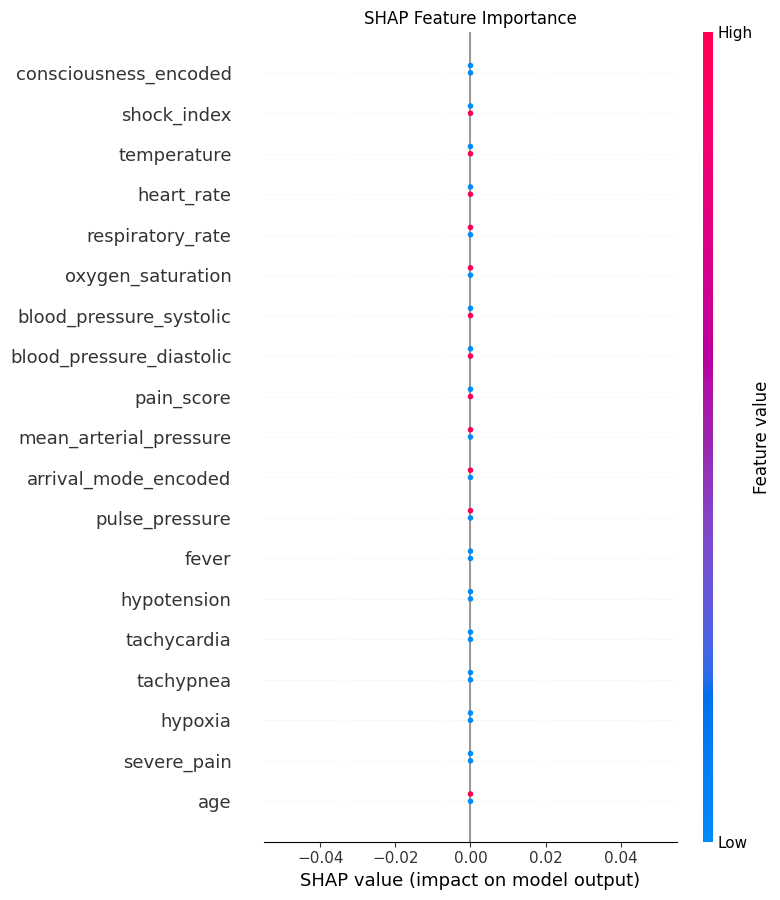

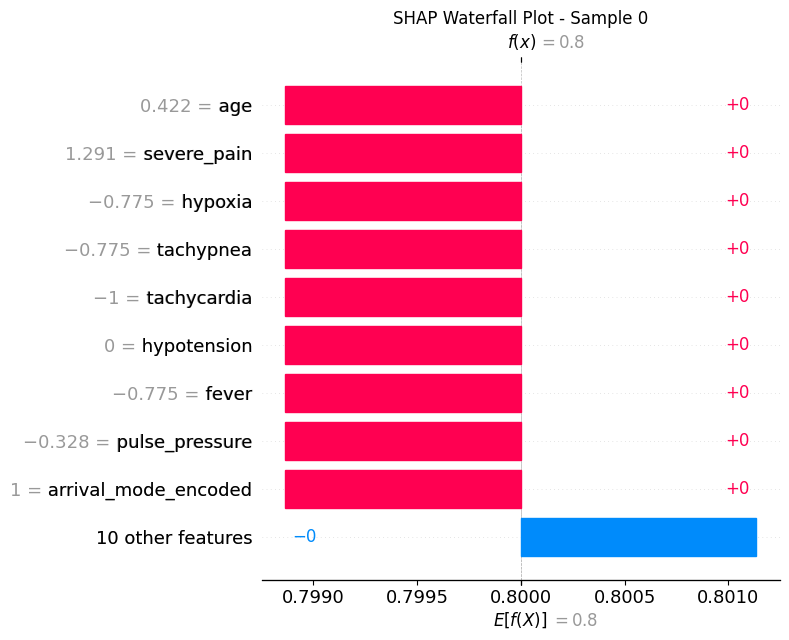

In [30]:
# SHAP Interpretability
print("Generating SHAP explanations...")

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_struct_scaled)

# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_struct_scaled, feature_names=structured_features, show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# SHAP waterfall plot for single prediction
sample_idx = 0
plt.figure(figsize=(12, 6))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[sample_idx],
        base_values=explainer.expected_value,
        data=X_test_struct_scaled[sample_idx],
        feature_names=structured_features
    ),
    show=False
)
plt.title(f'SHAP Waterfall Plot - Sample {sample_idx}')
plt.tight_layout()
plt.show()

Generating LIME explanations...


<Figure size 1200x600 with 0 Axes>

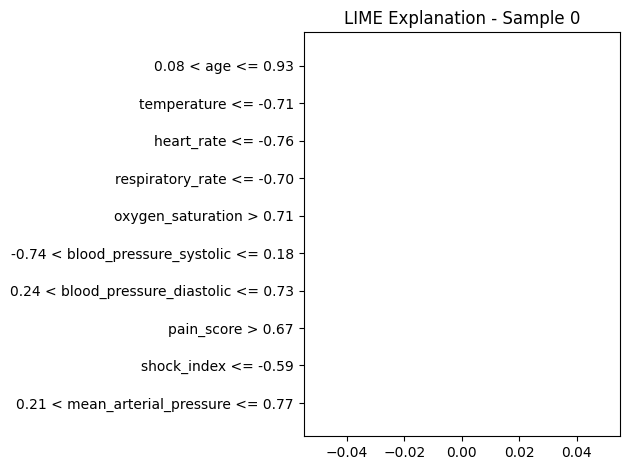

LIME Explanation:
[('0.08 < age <= 0.93', 0.0), ('temperature <= -0.71', 0.0), ('heart_rate <= -0.76', 0.0), ('respiratory_rate <= -0.70', 0.0), ('oxygen_saturation > 0.71', 0.0), ('-0.74 < blood_pressure_systolic <= 0.18', 0.0), ('0.24 < blood_pressure_diastolic <= 0.73', 0.0), ('pain_score > 0.67', 0.0), ('shock_index <= -0.59', 0.0), ('0.21 < mean_arterial_pressure <= 0.77', 0.0)]


In [31]:
# LIME Interpretability
print("Generating LIME explanations...")

# Create LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_struct_scaled,
    feature_names=structured_features,
    class_names=['Non-urgent', 'Urgent'],
    mode='classification'
)

# Explain single prediction
sample_idx = 0
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_struct_scaled[sample_idx],
    predict_fn=xgb_model.predict_proba,
    num_features=10
)

# Plot LIME explanation
plt.figure(figsize=(12, 6))
lime_exp.as_pyplot_figure()
plt.title(f'LIME Explanation - Sample {sample_idx}')
plt.tight_layout()
plt.show()

print("LIME Explanation:")
print(lime_exp.as_list())

In [33]:
# Fairness Assessment
print("Conducting fairness assessment...")

# Add demographic information (simulated)
test_df = X_test_struct.copy()
test_df['gender'] = np.random.choice(['Male', 'Female'], len(test_df))
test_df['race'] = np.random.choice(['White', 'Black', 'Hispanic', 'Asian', 'Other'], len(test_df))
test_df['age_group'] = pd.cut(test_df['age'], bins=[0, 30, 50, 70, 100], 
                             labels=['18-30', '31-50', '51-70', '71+'])
test_df['predictions'] = ensemble_pred
test_df['actual'] = y_test  # <- fixed

# Calculate fairness metrics
def calculate_fairness_metrics(df, protected_attr, outcome):
    groups = df[protected_attr].unique()
    metrics = {}
    
    for group in groups:
        group_data = df[df[protected_attr] == group]
        if len(group_data) > 0:
            pred_positive = group_data[outcome].mean()
            actual_positive = group_data['actual'].mean()
            metrics[group] = {
                'predicted_positive_rate': pred_positive,
                'actual_positive_rate': actual_positive,
                'size': len(group_data)
            }
    
    return metrics

# Gender fairness
gender_fairness = calculate_fairness_metrics(test_df, 'gender', 'predictions')
print("Gender Fairness Metrics:")
for group, metrics in gender_fairness.items():
    print(f"{group}: Predicted positive rate = {metrics['predicted_positive_rate']:.3f}, "
          f"Actual positive rate = {metrics['actual_positive_rate']:.3f}, "
          f"Sample size = {metrics['size']}")

# Age group fairness
age_fairness = calculate_fairness_metrics(test_df, 'age_group', 'predictions')
print("\nAge Group Fairness Metrics:")
for group, metrics in age_fairness.items():
    print(f"{group}: Predicted positive rate = {metrics['predicted_positive_rate']:.3f}, "
          f"Actual positive rate = {metrics['actual_positive_rate']:.3f}, "
          f"Sample size = {metrics['size']}")

# Calculate disparate impact
def disparate_impact(metrics_dict, privileged_group, unprivileged_group):
    if privileged_group in metrics_dict and unprivileged_group in metrics_dict:
        priv_rate = metrics_dict[privileged_group]['predicted_positive_rate']
        unpriv_rate = metrics_dict[unprivileged_group]['predicted_positive_rate']
        if priv_rate > 0:
            return unpriv_rate / priv_rate
    return None

# Example disparate impact calculation
di_gender = disparate_impact(gender_fairness, 'Male', 'Female')
if di_gender is not None:
    print(f"\nDisparate Impact (Female/Male): {di_gender:.3f}")
    if di_gender < 0.8:
        print("⚠️ Potential discrimination detected!")
    else:
        print("✅ Fair distribution")


Conducting fairness assessment...
Gender Fairness Metrics:
Female: Predicted positive rate = 1.000, Actual positive rate = 0.000, Sample size = 1
Male: Predicted positive rate = 1.000, Actual positive rate = 1.000, Sample size = 1

Age Group Fairness Metrics:
51-70: Predicted positive rate = 1.000, Actual positive rate = 0.000, Sample size = 1
18-30: Predicted positive rate = 1.000, Actual positive rate = 1.000, Sample size = 1

Disparate Impact (Female/Male): 1.000
✅ Fair distribution


In [34]:
# Counterfactual Generation
print("Generating counterfactual explanations...")

def generate_counterfactual(sample, model, feature_names, target_class=1, max_iterations=100):
    """Generate counterfactual explanation by finding minimal changes to flip prediction"""
    original_pred = model.predict_proba(sample.reshape(1, -1))[0]
    original_class = np.argmax(original_pred)
    
    if original_class == target_class:
        return None, "Already in target class"
    
    # Start with original sample
    counterfactual = sample.copy()
    changes = {}
    
    # Try changing each feature individually
    for i, feature_name in enumerate(feature_names):
        # Try small perturbations
        for direction in [-1, 1]:
            for magnitude in [0.1, 0.5, 1.0, 2.0]:
                temp_sample = counterfactual.copy()
                temp_sample[i] += direction * magnitude * np.std(sample)  # Scale by feature std
                
                new_pred = model.predict_proba(temp_sample.reshape(1, -1))[0]
                new_class = np.argmax(new_pred)
                
                if new_class == target_class:
                    changes[feature_name] = temp_sample[i] - sample[i]
                    counterfactual = temp_sample
                    break
            if feature_name in changes:
                break
        
        if len(changes) >= 3:  # Limit to 3 changes for interpretability
            break
    
    return changes, counterfactual

# Generate counterfactual for a sample
sample_idx = 0
sample_data = X_test_struct_scaled[sample_idx]
changes, counterfactual = generate_counterfactual(
    sample_data, xgb_model, structured_features
)

print(f"Counterfactual for Sample {sample_idx}:")
if changes:
    print("Changes needed to flip prediction to Urgent:")
    for feature, change in changes.items():
        print(f"  {feature}: {change:.3f}")
else:
    print("No counterfactual found or already urgent")

Generating counterfactual explanations...
Counterfactual for Sample 0:
No counterfactual found or already urgent


In [39]:
print("Setting up MLflow experiment tracking...")

mlflow.set_experiment("ED-AI-Triage-Advanced")

with mlflow.start_run(run_name="Advanced-Triage-Ensemble"):
    # Log parameters
    mlflow.log_param("xgb_max_depth", xgb_params['max_depth'])
    mlflow.log_param("xgb_learning_rate", xgb_params['learning_rate'])
    mlflow.log_param("lgb_num_leaves", lgb_params['num_leaves'])
    mlflow.log_param("ensemble_method", "simple_average")
    
    # Log metrics
    mlflow.log_metric("auc", roc_auc_score(y_test, ensemble_proba))
    mlflow.log_metric("pr_auc", average_precision_score(y_test, ensemble_proba))
    mlflow.log_metric("brier_score", brier_score_loss(y_test, ensemble_proba))
    
    # Log models safely
    mlflow.xgboost.log_model(xgb_model, artifact_path="xgboost_model")
    mlflow.lightgbm.log_model(lgb_model, artifact_path="lightgbm_model")
    mlflow.sklearn.log_model(scaler, artifact_path="scaler")
    
    # Log feature importance (make sure lengths match)
    fi = xgb_model.feature_importances_
    fi_names = structured_features[:len(fi)]  # truncate if needed
    feature_importance = pd.DataFrame({
        'feature': fi_names,
        'importance': fi
    })
    feature_importance.to_csv("feature_importance.csv", index=False)
    mlflow.log_artifact("feature_importance.csv")
    
    print("MLflow run completed!")
    print(f"Run ID: {mlflow.active_run().info.run_id}")


2025/09/08 01:19:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Setting up MLflow experiment tracking...


2025/09/08 01:19:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/08 01:19:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/08 01:19:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/08 01:19:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/08 01:19:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/09/08 01:19:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow run completed!
Run ID: 970cd90346df46d2a5ac9a6095499d9b


In [40]:
# Save models and preprocessing objects
print("Saving advanced models and preprocessing objects...")

# Save models
joblib.dump(xgb_model, '../models/xgb_model.joblib')
joblib.dump(lgb_model, '../models/lgb_model.joblib')
joblib.dump(scaler, '../models/advanced_scaler.joblib')
joblib.dump(structured_features, '../models/structured_features.joblib')

# Save ClinicalBERT components
joblib.dump(tokenizer, '../models/bert_tokenizer.joblib')
torch.save(bert_model.state_dict(), '../models/bert_model.pth')

# Save SHAP explainer
joblib.dump(explainer, '../models/shap_explainer.joblib')

print("All models and preprocessing objects saved!")
print("Files saved:")
print("- ../models/xgb_model.joblib")
print("- ../models/lgb_model.joblib")
print("- ../models/advanced_scaler.joblib")
print("- ../models/structured_features.joblib")
print("- ../models/bert_tokenizer.joblib")
print("- ../models/bert_model.pth")
print("- ../models/shap_explainer.joblib")

# Test prediction on sample data
sample_data = X_test_struct_scaled[:3]
xgb_predictions = xgb_model.predict_proba(sample_data)
lgb_predictions = lgb_model.predict_proba(sample_data)
ensemble_predictions = (xgb_predictions + lgb_predictions) / 2

print("\nSample Predictions (Ensemble):")
for i, pred in enumerate(ensemble_predictions):
    print(f"Sample {i+1}: Urgent probability = {pred[1]:.3f}, "
          f"Predicted class = {'Urgent' if pred[1] > 0.5 else 'Non-urgent'}")

Saving advanced models and preprocessing objects...
All models and preprocessing objects saved!
Files saved:
- ../models/xgb_model.joblib
- ../models/lgb_model.joblib
- ../models/advanced_scaler.joblib
- ../models/structured_features.joblib
- ../models/bert_tokenizer.joblib
- ../models/bert_model.pth
- ../models/shap_explainer.joblib

Sample Predictions (Ensemble):
Sample 1: Urgent probability = 0.782, Predicted class = Urgent
Sample 2: Urgent probability = 0.782, Predicted class = Urgent
